Part 3

# Neural Networks

Now we will implement neural networks to predict the bodyfat.
In this notebook, we will focus on two examples: A linear regression using a network with one linear layer and no activation function; and a neural network with three layers with softmax activation.

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

# Data Preparation

In [ ]:
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_train=X_train.values

Y_train=Y_train.values

X_test=X_test.values

Y_test=Y_test.values

X_val=X_val.values

Y_val=Y_val.values

scaler=MinMaxScaler()

scaler.fit(X_train)

#normalize the features in the training set
X_train_s = scaler.transform(X_train)
#normalize the features in the test set
X_test_s = scaler.transform(X_test)
#normalize the features in the validation set
X_val_s = scaler.transform(X_val)

In [ ]:
from torch.utils.data import Dataset as torch_dataset
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        # return a data point (x,y) by idx (index)
        # we need to convert numpy array to torch tensor
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

In [ ]:
dataset_train = MyDataset(X_train_s, Y_train)
dataset_val = MyDataset(X_val_s, Y_val)
dataset_test = MyDataset(X_test_s, Y_test)

In [ ]:
from torch.utils.data import DataLoader as torch_dataloader
dataloader_train = torch_dataloader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
dataloader_val = torch_dataloader(dataset_val, batch_size=64, shuffle=False, num_workers=0) 
dataloader_test = torch_dataloader(dataset_test, batch_size=64, shuffle=False, num_workers=0) 

In [ ]:
for epoch in range(0, 1): # change 1 to 100 if we need to train the model for 100 epochs
    for batch_idx, (X, Y) in enumerate(dataloader_train):
        print(batch_idx, X.shape, Y.shape)

0 torch.Size([64, 20]) torch.Size([64, 1])
1 torch.Size([64, 20]) torch.Size([64, 1])
2 torch.Size([64, 20]) torch.Size([64, 1])
3 torch.Size([34, 20]) torch.Size([34, 1])


# Creating the Network:
Our first network has only a linear layer - linear regression

In [ ]:
import torch.nn as nn
class Net(nn.Module): 
    def __init__(self, input_dim, output_dim):
        super().__init__() 
        self.layer1 = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        y=self.layer1(x)
        return y

In [ ]:
model=Net(input_dim=20, output_dim=1)

In [ ]:
x=torch.rand(1,20) # Testing
z=model(x)

In [ ]:
z

tensor([[-0.1626]], grad_fn=<AddmmBackward0>)

In [ ]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter, dL/dW=0
        Yp = model(X)#forward pass
        loss = torch.mean((Yp-Y)**2) # MSE loss or other loss
        loss.backward()#backward pass to get dL/dW
        optimizer.step()#update parameters:  W <= w - lr *dL/dW
        loss_train+=loss.item()#always use .item()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    return loss_train

In [ ]:
def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    mae_test=0
    sample_count=0
    with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Yp = model(X)#forward pass
            loss_test+=torch.sum((Yp-Y)**2).item()
            mae_test+= torch.sum((Yp-Y).abs()).item()
            sample_count+=X.size(0)
    loss_test/=sample_count
    mae_test/=sample_count
    return loss_test, mae_test

In [ ]:
loss_train_list=[]
loss_val_list=[]

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer1): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train=train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    #-------- perform validation --------------------------------
    loss_val, mae_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

Train Epoch: 0 [0/226 (0%)]	Loss: 438.427277
Train Epoch: 0 [64/226 (25%)]	Loss: 426.846985
Train Epoch: 0 [128/226 (50%)]	Loss: 172.717300
Train Epoch: 0 [102/226 (75%)]	Loss: 149.008667
epoch 0 training loss: 296.750057220459
epoch 0 validation loss: 49.07718599759615
Train Epoch: 1 [0/226 (0%)]	Loss: 59.186111
Train Epoch: 1 [64/226 (25%)]	Loss: 48.127182
Train Epoch: 1 [128/226 (50%)]	Loss: 82.844437
Train Epoch: 1 [102/226 (75%)]	Loss: 84.892570
epoch 1 training loss: 68.76257514953613
epoch 1 validation loss: 157.68055138221155
Train Epoch: 2 [0/226 (0%)]	Loss: 175.024750
Train Epoch: 2 [64/226 (25%)]	Loss: 212.201431
Train Epoch: 2 [128/226 (50%)]	Loss: 165.238022
Train Epoch: 2 [102/226 (75%)]	Loss: 158.276749
epoch 2 training loss: 177.68523788452148
epoch 2 validation loss: 82.39725435697116
Train Epoch: 3 [0/226 (0%)]	Loss: 99.126282
Train Epoch: 3 [64/226 (25%)]	Loss: 69.173515
Train Epoch: 3 [128/226 (50%)]	Loss: 43.467293
Train Epoch: 3 [102/226 (75%)]	Loss: 39.786293
epo

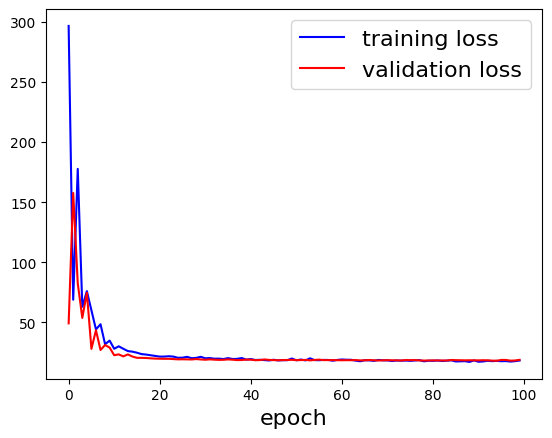

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax.plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax.set_xlabel('epoch',fontsize=16)
ax.legend(fontsize=16)

# Training results:

In [ ]:
X_train_t=torch.tensor(X_train_s, dtype=torch.float32) #convert numpy array to torch tensor
#the input to model should be torch tensor
Y_train_pred_t=model(X_train_t.to(device))
Y_train_pred=Y_train_pred_t.detach().cpu().numpy() #convert torch tensor to numpy array

Text(0.5, 1.0, 'MSE=17.640447575861288, MAE=3.4764228966383803, R2=0.7483344580328054')

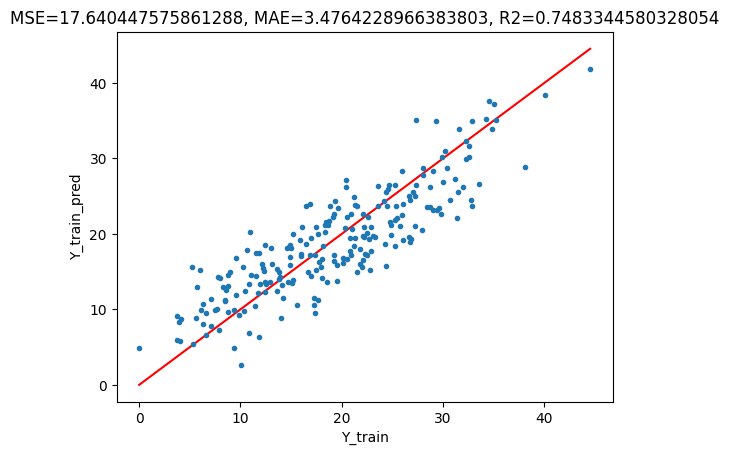

In [ ]:
from sklearn.metrics import r2_score

MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
R2 = r2_score(Y_train, Y_train_pred)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))

# Testing results:

In [ ]:
X_test_t=torch.tensor(X_test_s, dtype=torch.float32) #convert numpy array to torch tensor
#the input to model should be torch tensor
Y_test_pred_t=model(X_test_t.to(device))
Y_test_pred=Y_test_pred_t.detach().cpu().numpy() #convert torch tensor to numpy array

Text(0.5, 1.0, 'MSE=15.025585344796182, MAE=3.077191663255879, R2=0.792243264563607')

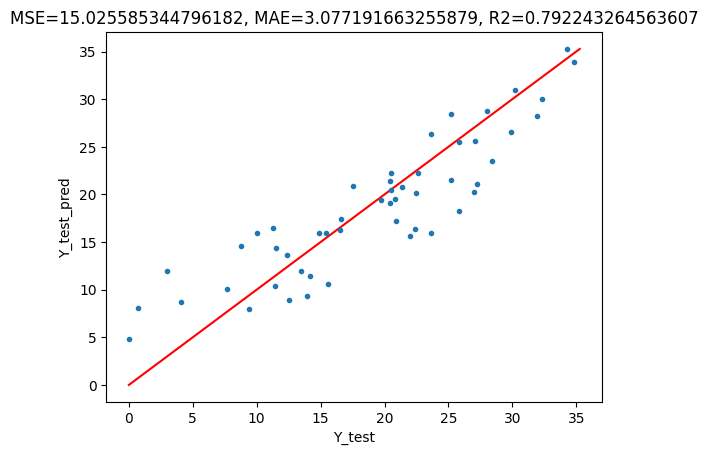

In [ ]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
R2 = r2_score(Y_test, Y_test_pred)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))

# Creating a second Neural Network:
This one will have two layers with ReLu activation

In [ ]:
import torch.nn.functional as nnF
import torch.nn as nn

class Net_nonlin(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(20, 32)
        self.layer2 = nn.Linear(32, 1)          
    def forward(self, x):
        x=self.layer1(x)
        x=nnF.relu(x)
        y=self.layer2(x)
        return y

In [ ]:
model=Net_nonlin()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net_nonlin(
  (layer1): Linear(in_features=20, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

loss_train_list=[]
loss_val_list=[]

for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train=train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    #-------- perform validation --------------------------------
    loss_val, mae_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

Train Epoch: 0 [0/226 (0%)]	Loss: 403.624939
Train Epoch: 0 [64/226 (25%)]	Loss: 405.216156
Train Epoch: 0 [128/226 (50%)]	Loss: 222.479004
Train Epoch: 0 [102/226 (75%)]	Loss: 215.160233
epoch 0 training loss: 311.6200828552246
epoch 0 validation loss: 56.3138192983774
Train Epoch: 1 [0/226 (0%)]	Loss: 78.604492
Train Epoch: 1 [64/226 (25%)]	Loss: 133.366943
Train Epoch: 1 [128/226 (50%)]	Loss: 146.168518
Train Epoch: 1 [102/226 (75%)]	Loss: 59.227989
epoch 1 training loss: 104.34198570251465
epoch 1 validation loss: 139.46858097956732
Train Epoch: 2 [0/226 (0%)]	Loss: 141.246704
Train Epoch: 2 [64/226 (25%)]	Loss: 44.713570
Train Epoch: 2 [128/226 (50%)]	Loss: 89.262444
Train Epoch: 2 [102/226 (75%)]	Loss: 111.111816
epoch 2 training loss: 96.58363342285156
epoch 2 validation loss: 29.89543738731971
Train Epoch: 3 [0/226 (0%)]	Loss: 32.224190
Train Epoch: 3 [64/226 (25%)]	Loss: 46.640221
Train Epoch: 3 [128/226 (50%)]	Loss: 45.279438
Train Epoch: 3 [102/226 (75%)]	Loss: 34.031525
epo

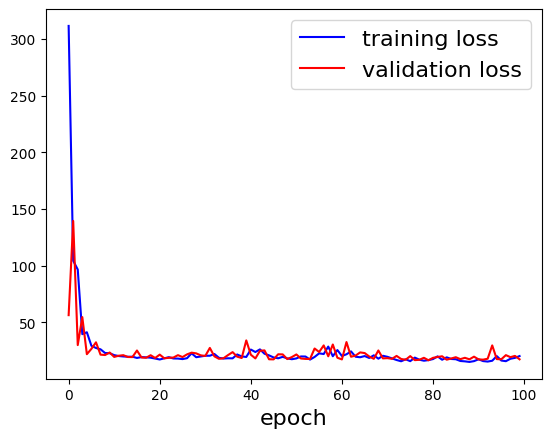

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax.plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax.set_xlabel('epoch',fontsize=16)
ax.legend(fontsize=16)

# Training results:

In [ ]:
X_train_t=torch.tensor(X_train_s, dtype=torch.float32) #convert numpy array to torch tensor
#the input to model should be torch tensor
Y_train_pred_t=model(X_train_t.to(device))
Y_train_pred=Y_train_pred_t.detach().cpu().numpy() #convert torch tensor to numpy array

Text(0.5, 1.0, 'MSE=15.283011612031167, MAE=3.2400186188453066, R2=0.7819665638475184')

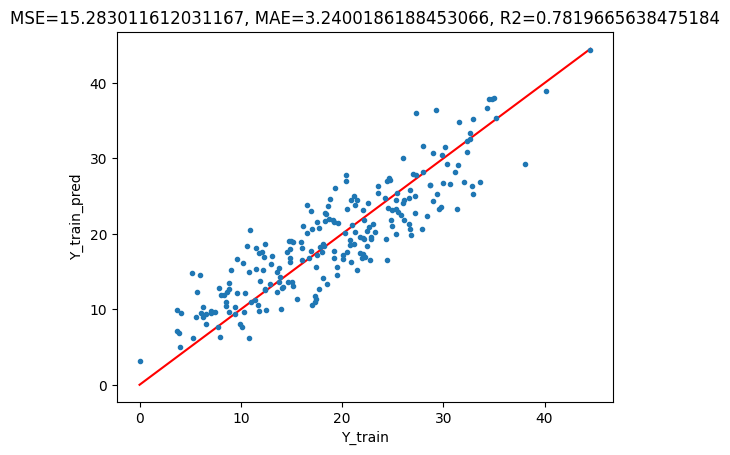

In [ ]:
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
R2 = r2_score(Y_train, Y_train_pred)
#
ymax=np.max([Y_train.max(), Y_train_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_train, Y_train_pred, '.')
plt.xlabel('Y_train')
plt.ylabel('Y_train_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))

# Testing results:

In [ ]:
X_test_t=torch.tensor(X_test_s, dtype=torch.float32) #convert numpy array to torch tensor
#the input to model should be torch tensor
Y_test_pred_t=model(X_test_t.to(device))
Y_test_pred=Y_test_pred_t.detach().cpu().numpy() #convert torch tensor to numpy array

Text(0.5, 1.0, 'MSE=14.192377568695425, MAE=3.080017746196073, R2=0.8037639157416233')

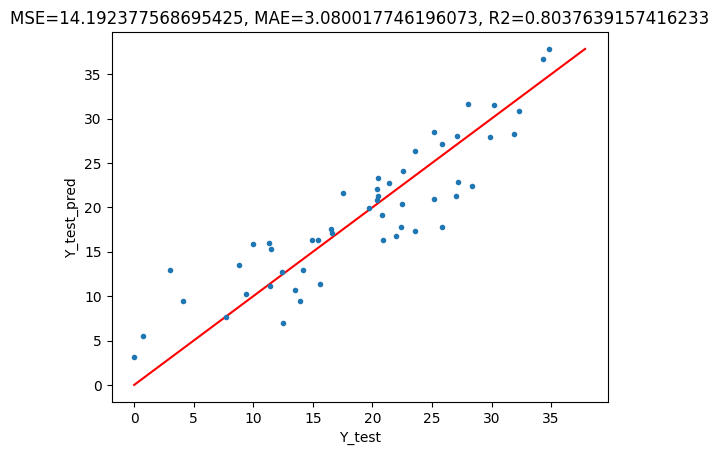

In [ ]:
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
R2 = r2_score(Y_test, Y_test_pred)
#
ymax=np.max([Y_test.max(), Y_test_pred.max()])
plt.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
plt.plot(Y_test, Y_test_pred, '.')
plt.xlabel('Y_test')
plt.ylabel('Y_test_pred')
plt.title('MSE='+str(MSE)+', MAE='+str(MAE)+', R2='+str(R2))

# Conclusion part 3

Both Neural Networks performed slightly above the average compared to the models we tried until now. The nonlinear network is the best until now, with an R2 score of 0.8 on the test set.

Our latest models have shown slightly better performance than the average. The nonlinear network has been the top performer so far, achieving an R2 score of 0.8 on the test set.